In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import time
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from tools import *
datadir = '/'.join(os.getcwd().split('/')[:-1])+"/2_Data/"
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)


In [3]:
raw = pd.read_csv(datadir+'train.csv')
meta_df = pd.read_csv(datadir+'building_metadata.csv')

In [4]:
@logger
def select_meter(df, meter=0):
    return df[df.meter==0]

@logger
def drop_outliers(df, threshold=5000):
    return df[df.meter_reading<threshold]

@logger
def to_datetime(df):
    df.timestamp = pd.to_datetime(df.timestamp)
    return df

In [8]:
df = (raw.pipe(start_pipeline)
         .pipe(reduce_mem_usage)
         .pipe(select_meter)
         .pipe(drop_outliers)   
         .pipe(to_datetime)
     )
     

df = df.set_index('building_id').join(meta_df.set_index('building_id'))

df = df[df.primary_use == 'Lodging/residential']
df.set_index('timestamp', inplace=True)


start_pipeline took 0:00:00 secs, shape(20216100, 4)
Mem. usage decreased to 289.19 Mb (53.1% reduction)
reduce_mem_usage took 0:00:00 secs, shape(20216100, 4)
select_meter took 0:00:00 secs, shape(12060910, 4)
drop_outliers took 0:00:00 secs, shape(12049079, 4)
to_datetime took 0:00:00 secs, shape(12049079, 4)


In [47]:
df

,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
timestamp,,,,,,,
2016-01-01 00:00:00,0,0.000000,0,Lodging/residential,27926,1981.0,NaN
2016-01-01 01:00:00,0,0.000000,0,Lodging/residential,27926,1981.0,NaN
2016-01-01 02:00:00,0,0.000000,0,Lodging/residential,27926,1981.0,NaN
2016-01-01 03:00:00,0,0.000000,0,Lodging/residential,27926,1981.0,NaN
2016-01-01 04:00:00,0,0.000000,0,Lodging/residential,27926,1981.0,NaN
...,...,...,...,...,...,...,...
2016-12-31 19:00:00,0,167.800003,15,Lodging/residential,29775,2001.0,NaN
2016-12-31 20:00:00,0,168.149994,15,Lodging/residential,29775,2001.0,NaN
2016-12-31 21:00:00,0,164.074997,15,Lodging/residential,29775,2001.0,NaN


In [46]:
data = df[[ 'meter_reading']]
y = data.resample('D').mean().values
#univariete_tensor = torch.Tensor(univariete.values)
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=366, D=1


In [43]:
# scale
y -= y.mean()
y /= y.std()

In [44]:
ix_train = range(45)
ix_test = range(45,53)
N_train = len(ix_train)
N_test = len(ix_test)
print("N_train:", N_train)
print("N_test:", N_test)
y_train = y[ix_train,:]
y_test = y[ix_test,:]

N_train: 45
N_test: 8


In [45]:
def f(carry, noise_t):
    beta1, beta2, z_prev1, z_prev2, tau = carry
    z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise_t
    z_prev1 = z_prev2
    z_prev2 = z_t
    return (beta1, beta2, z_prev1, z_prev2, tau), z_t
def model(T, T_forecast, obs=None):
    """ Define priors over beta1, beta2, tau, noises, sigma, z_prev1 and z_prev2 (keep the shapes in mind)
    # Your code here
    """
    beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0., scale=5.))
    beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0., scale=5.))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=5.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 10.), sample_shape=(T+T_forecast-2,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=5.))
    z_prev1 = numpyro.sample(name="z_1", fn=dist.Normal(loc=0., scale=5.))
    z_prev2 = numpyro.sample(name="z_2", fn=dist.Normal(loc=0., scale=5.))
    
    """ Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    # Your code here
    """
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_pred) - note that you don't need a pyro.plate!
    # Your code here
    """
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None)
    

In [36]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N_train, T_forecast=N_test, obs=y_train[:,0])

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 4000/4000 [00:14<00:00, 271.87it/s, 1 steps of size 5.00e-03. acc. prob=0.00]


Total time: 0.309m


In [37]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_1      0.83      0.00      0.83      0.83      0.83       nan       nan
    beta_2      1.08      0.00      1.08      1.08      1.08      0.50      1.00
 noises[0]     -0.88      0.00     -0.88     -0.88     -0.88      0.50      1.00
 noises[1]      0.15      0.00      0.15      0.15      0.15      0.50      1.00
 noises[2]     -0.52      0.00     -0.52     -0.52     -0.52      0.50      1.00
 noises[3]      1.00      0.00      1.00      1.00      1.00      0.50      1.00
 noises[4]      0.10      0.00      0.10      0.10      0.10      0.50      1.00
 noises[5]      1.68      0.00      1.68      1.68      1.68      0.50      1.00
 noises[6]     -0.00      0.00     -0.00     -0.00     -0.00       nan       nan
 noises[7]      0.09      0.00      0.09      0.09      0.09      0.50      1.00
 noises[8]     -0.93      0.00     -0.93     -0.93     -0.93      0.50      1.00
 noises[9]     -1.97      0

In [38]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

/home/evangelos/.cache/pypoetry/virtualenvs/mbml-energy-predictor-fRCGeReP-py3.8/lib/python3.8/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


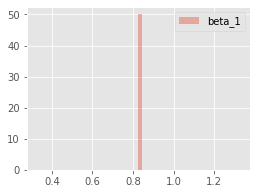

/home/evangelos/.cache/pypoetry/virtualenvs/mbml-energy-predictor-fRCGeReP-py3.8/lib/python3.8/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


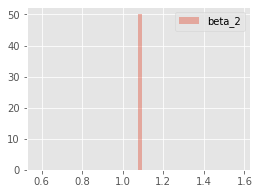

/home/evangelos/.cache/pypoetry/virtualenvs/mbml-energy-predictor-fRCGeReP-py3.8/lib/python3.8/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


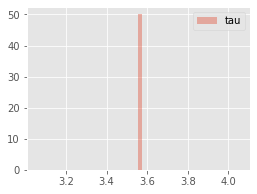

/home/evangelos/.cache/pypoetry/virtualenvs/mbml-energy-predictor-fRCGeReP-py3.8/lib/python3.8/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


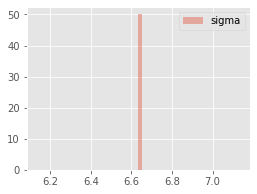

In [39]:
nodes = ["beta_1", "beta_2", "tau", "sigma"]
for node in nodes:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

In [40]:
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean

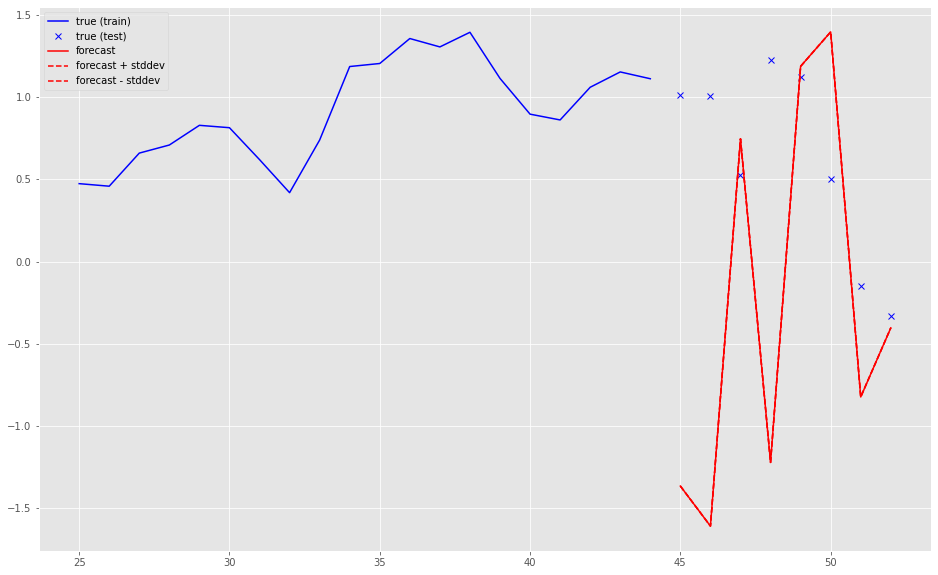

In [41]:
plt.plot(ix_train[-20:], y_train[-20:, 0], "b-")
plt.plot(ix_test, y_test[:, 0], "bx")
plt.plot(ix_test, y_pred_mean, "r-")
plt.plot(ix_test, y_pred_025, "r--")
plt.plot(ix_test, y_pred_975, "r--")
plt.fill_between(ix_test, y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()